In [1]:
#Import Python Libraries

#data analysis
import numpy as np
import pandas as pd
from __future__ import print_function

#modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from statistics import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#text analysis
from textblob import TextBlob
import string
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Guardian API
import requests 
import json

#network analysis
import networkx as nx
import pydot as pydot

In [2]:
#Load data from Kaggle
df = pd.read_csv('recipe_10000.csv')
df_reviews = pd.read_csv('reviews.csv')

****

Explore the recipes and reviews files. Combine the two. Do some basic exploratory analysis. Perform some feature engineering 

****

In [3]:
#start with the recipe file and view the data
df.head(5)

Unnamed: 0  index  RecipeId                               Name CookTime  \
0           0      0        38  Low-Fat Berry Blue Frozen Dessert    PT24H   
1           1      4        39                            Biryani    PT25M   
2           2      5        40                      Best Lemonade     PT5M   
3           3     14        41     Carina's Tofu-Vegetable Kebabs    PT20M   
4           4     16        42                       Cabbage Soup    PT30M   

  PrepTime TotalTime                                        Description  \
0    PT45M  PT24H45M  Make and share this Low-Fat Berry Blue Frozen ...   
1     PT4H   PT4H25M  Make and share this Biryani recipe from Food.com.   
2    PT30M     PT35M  This is from one of my  first Good House Keepi...   
3    PT24H  PT24H20M  This dish is best prepared a day in advance to...   
4    PT20M     PT50M  Make and share this Cabbage Soup recipe from F...   

                                              Images   RecipeCategory  \
0  ['https://img.sndimg.com/food/image/upload/w_5...  Frozen Desserts   
1  ['https://img.sndimg.com/food/image/upload/w_5...   Chicken Breast   
2  ['https://img.sndimg.com/food/image/upload/w_5...        Beverages   
3  ['https://img.sndimg.com/food/image/upload/w_5...         Soy/Tofu   
4  ['https://img.sndimg.com/food/image/upload/w_5...        Vegetable   

                                            Keywords  \
0  ['Dessert', 'Low Protein', 'Low Cholesterol', ...   
1  ['Chicken Thigh & Leg', 'Chicken', 'Poultry', ...   
2  ['Low Protein', 'Low Cholesterol', 'Healthy', ...   
3  ['Beans', 'Vegetable', 'Low Cholesterol', 'Wee...   
4  ['Low Protein', 'Vegan', 'Low Cholesterol', 'H...   

                          RecipeIngredientQuantities  \
0                             ['4', '1/4', '1', '1']   
1  ['1', '4', '2', '2', '8', '1/4', '8', '1/2', '...   
2                     ['1 1/2', '1', '1 1/2', '3/4']   
3  ['12', '1', '2', '1', '10', '1', '3', '2', '2'...   
4                         ['46', '4', '1', '2', '1']   

                               RecipeIngredientParts  AggregatedRating  \
0  ['blueberries', 'granulated sugar', 'vanilla y...               4.5   
1  ['saffron', 'milk', 'hot green chili peppers',...               3.0   
2  ['sugar', 'lemons, rind of', 'lemon, zest of',...               4.5   
3  ['extra firm tofu', 'eggplant', 'zucchini', 'm...               4.5   
4  ['plain tomato juice', 'cabbage', 'onion', 'ca...               4.5   

   Calories  RecipeServings RecipeYield  \
0     170.9             4.0         NaN   
1    1110.7             6.0         NaN   
2     311.1             4.0         NaN   
3     536.1             2.0    4 kebabs   
4     103.6             4.0         NaN   

                                  RecipeInstructions  \
0  ['Toss 2 cups berries with sugar.', 'Let stand...   
1  ['Soak saffron in warm milk for 5 minutes and ...   
2  ['Into a 1 quart Jar with tight fitting lid, p...   
3  ['Drain the tofu, carefully squeezing out exce...   
4  ['Mix everything together and bring to a boil....   

                                     reviews_in_dict  
0  {579149: {'Rating': 5, 'Review': 'Yummy, yummy...  
1  {361851: {'Rating': 3, 'Review': 'I have an In...  
2  {34854: {'Rating': 5, 'Review': "My favourite ...  
3  {48870: {'Rating': 5, 'Review': 'I thought thi...  
4  {46368: {'Rating': 5, 'Review': 'This is a ver...

In [4]:
#find number of rows and columns
df.shape

(10000, 19)

In [5]:
#reduce dataframe to relevant columns
df_recipes = df[['index','RecipeId', 'Name','Description', 'RecipeCategory','RecipeIngredientParts',
                 'RecipeInstructions', 'Keywords', 'AggregatedRating']]
df_recipes.head()

index  RecipeId                               Name  \
0      0        38  Low-Fat Berry Blue Frozen Dessert   
1      4        39                            Biryani   
2      5        40                      Best Lemonade   
3     14        41     Carina's Tofu-Vegetable Kebabs   
4     16        42                       Cabbage Soup   

                                         Description   RecipeCategory  \
0  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
1  Make and share this Biryani recipe from Food.com.   Chicken Breast   
2  This is from one of my  first Good House Keepi...        Beverages   
3  This dish is best prepared a day in advance to...         Soy/Tofu   
4  Make and share this Cabbage Soup recipe from F...        Vegetable   

                               RecipeIngredientParts  \
0  ['blueberries', 'granulated sugar', 'vanilla y...   
1  ['saffron', 'milk', 'hot green chili peppers',...   
2  ['sugar', 'lemons, rind of', 'lemon, zest of',...   
3  ['extra firm tofu', 'eggplant', 'zucchini', 'm...   
4  ['plain tomato juice', 'cabbage', 'onion', 'ca...   

                                  RecipeInstructions  \
0  ['Toss 2 cups berries with sugar.', 'Let stand...   
1  ['Soak saffron in warm milk for 5 minutes and ...   
2  ['Into a 1 quart Jar with tight fitting lid, p...   
3  ['Drain the tofu, carefully squeezing out exce...   
4  ['Mix everything together and bring to a boil....   

                                            Keywords  AggregatedRating  
0  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5  
1  ['Chicken Thigh & Leg', 'Chicken', 'Poultry', ...               3.0  
2  ['Low Protein', 'Low Cholesterol', 'Healthy', ...               4.5  
3  ['Beans', 'Vegetable', 'Low Cholesterol', 'Wee...               4.5  
4  ['Low Protein', 'Vegan', 'Low Cholesterol', 'H...               4.5

In [6]:
#Create column for length of recipe instructions
df_recipes['instr_len'] = df_recipes['RecipeInstructions'].str.len()

<ipython-input-6-44fbeba64109>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recipes['instr_len'] = df_recipes['RecipeInstructions'].str.len()


In [7]:
#check for missing values
df_recipes[df_recipes.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [index, RecipeId, Name, Description, RecipeCategory, RecipeIngredientParts, RecipeInstructions, Keywords, AggregatedRating, instr_len]
Index: []

In [8]:
#check for duplicates
df_recipes.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

<ipython-input-8-64fc0bdd1c27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recipes.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)


In [9]:
#explore the reviews file
df_reviews.head()

ReviewId  RecipeId  AuthorId        AuthorName  Rating  \
0         2       992      2008         gayg msft       5   
1         7      4384      1634     Bill Hilbrich       4   
2         9      4523      2046  Gay Gilmore ckpt       2   
3        13      7435      1773     Malarkey Test       5   
4        14        44      2085        Tony Small       5   

                                              Review         DateSubmitted  \
0       better than any you can get at a restaurant!  2000-01-25T21:44:00Z   
1  I cut back on the mayo, and made up the differ...  2001-10-17T16:49:59Z   
2  i think i did something wrong because i could ...  2000-02-25T09:00:00Z   
3  easily the best i have ever had.  juicy flavor...  2000-03-13T21:15:00Z   
4                                 An excellent dish.  2000-03-28T12:51:00Z   

           DateModified  
0  2000-01-25T21:44:00Z  
1  2001-10-17T16:49:59Z  
2  2000-02-25T09:00:00Z  
3  2000-03-13T21:15:00Z  
4  2000-03-28T12:51:00Z

In [10]:
#Shape
df_reviews.shape

(1401982, 8)

In [11]:
# keep just the date from the ISO formatted dates
df_reviews['DateSubmitted'] = df_reviews['DateSubmitted'].str[:10]
df_reviews['DateModified'] = df_reviews['DateModified'].str[:10]


In [12]:
# Now make them datetimes 
df_reviews['DateSubmitted'] = pd.to_datetime(df_reviews['DateSubmitted'])
df_reviews['DateModified'] = pd.to_datetime(df_reviews['DateModified'])
df_reviews['DateSubmitted'].dtype

dtype('<M8[ns]')

In [13]:
# Check reviews for duplicates - no duplicates
df_reviews.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
df_reviews.shape

(1401982, 8)

In [14]:
# Join recipes and reviews on RecipeID. 
df_combined = pd.merge(df_recipes, df_reviews, on="RecipeId")

In [15]:
df_combined.shape

(234115, 17)

In [16]:
df_combined.head()

index  RecipeId                               Name  \
0      0        38  Low-Fat Berry Blue Frozen Dessert   
1      0        38  Low-Fat Berry Blue Frozen Dessert   
2      0        38  Low-Fat Berry Blue Frozen Dessert   
3      0        38  Low-Fat Berry Blue Frozen Dessert   
4      4        39                            Biryani   

                                         Description   RecipeCategory  \
0  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
1  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
2  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
3  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
4  Make and share this Biryani recipe from Food.com.   Chicken Breast   

                               RecipeIngredientParts  \
0  ['blueberries', 'granulated sugar', 'vanilla y...   
1  ['blueberries', 'granulated sugar', 'vanilla y...   
2  ['blueberries', 'granulated sugar', 'vanilla y...   
3  ['blueberries', 'granulated sugar', 'vanilla y...   
4  ['saffron', 'milk', 'hot green chili peppers',...   

                                  RecipeInstructions  \
0  ['Toss 2 cups berries with sugar.', 'Let stand...   
1  ['Toss 2 cups berries with sugar.', 'Let stand...   
2  ['Toss 2 cups berries with sugar.', 'Let stand...   
3  ['Toss 2 cups berries with sugar.', 'Let stand...   
4  ['Soak saffron in warm milk for 5 minutes and ...   

                                            Keywords  AggregatedRating  \
0  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
1  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
2  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
3  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
4  ['Chicken Thigh & Leg', 'Chicken', 'Poultry', ...               3.0   

   instr_len  ReviewId    AuthorId          AuthorName  Rating  \
0        654    579149      596506       allisonsmommy       5   
1        654    789264     1060485           allyop135       4   
2        654   1448544  1802956262              ionnym       4   
3        654   1450744     2123645  DeliciousAsItLooks       4   
4       1124    361851      393254        cassiopeia94       3   

                                              Review DateSubmitted  \
0  Yummy, yummy, yummy! I am a big fan of fruit a...    2008-02-13   
1  very good!! the directions were alittle weird ...    2009-01-15   
2  This does taste great! I think the recipe need...    2014-07-22   
3  Tasty and refreshing! I love the creamy flavor...    2014-08-14   
4  I have an Indian friend who made this dish for...    2007-01-20   

  DateModified  
0   2008-02-13  
1   2009-01-15  
2   2014-07-22  
3   2014-08-14  
4   2007-01-20

In [17]:
# all recipes have a review
df_combined['RecipeId'].nunique()

10000

In [18]:
# add column for season
df_combined['DateSubmitted'] = pd.to_datetime(df_combined['DateSubmitted'])
seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer','summer', 'summer', 'fall', 'fall', 'fall', 'winter']
month_to_season = dict(zip(range(1,13), seasons))
df_combined['season'] = df_combined.DateSubmitted.dt.month.map(month_to_season)
df_combined.head()


index  RecipeId                               Name  \
0      0        38  Low-Fat Berry Blue Frozen Dessert   
1      0        38  Low-Fat Berry Blue Frozen Dessert   
2      0        38  Low-Fat Berry Blue Frozen Dessert   
3      0        38  Low-Fat Berry Blue Frozen Dessert   
4      4        39                            Biryani   

                                         Description   RecipeCategory  \
0  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
1  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
2  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
3  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
4  Make and share this Biryani recipe from Food.com.   Chicken Breast   

                               RecipeIngredientParts  \
0  ['blueberries', 'granulated sugar', 'vanilla y...   
1  ['blueberries', 'granulated sugar', 'vanilla y...   
2  ['blueberries', 'granulated sugar', 'vanilla y...   
3  ['blueberries', 'granulated sugar', 'vanilla y...   
4  ['saffron', 'milk', 'hot green chili peppers',...   

                                  RecipeInstructions  \
0  ['Toss 2 cups berries with sugar.', 'Let stand...   
1  ['Toss 2 cups berries with sugar.', 'Let stand...   
2  ['Toss 2 cups berries with sugar.', 'Let stand...   
3  ['Toss 2 cups berries with sugar.', 'Let stand...   
4  ['Soak saffron in warm milk for 5 minutes and ...   

                                            Keywords  AggregatedRating  \
0  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
1  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
2  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
3  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
4  ['Chicken Thigh & Leg', 'Chicken', 'Poultry', ...               3.0   

   instr_len  ReviewId    AuthorId          AuthorName  Rating  \
0        654    579149      596506       allisonsmommy       5   
1        654    789264     1060485           allyop135       4   
2        654   1448544  1802956262              ionnym       4   
3        654   1450744     2123645  DeliciousAsItLooks       4   
4       1124    361851      393254        cassiopeia94       3   

                                              Review DateSubmitted  \
0  Yummy, yummy, yummy! I am a big fan of fruit a...    2008-02-13   
1  very good!! the directions were alittle weird ...    2009-01-15   
2  This does taste great! I think the recipe need...    2014-07-22   
3  Tasty and refreshing! I love the creamy flavor...    2014-08-14   
4  I have an Indian friend who made this dish for...    2007-01-20   

  DateModified  season  
0   2008-02-13  winter  
1   2009-01-15  winter  
2   2014-07-22  summer  
3   2014-08-14  summer  
4   2007-01-20  winter

In [19]:
# count reviews by recipe category and season
cat_reviews = df_combined.groupby(['RecipeCategory','season'])[['Review']].count().sort_values(by='Review', ascending = False)
cat_reviews = cat_reviews.rename(columns={"Review": "count_review"})
cat_reviews['percentage'] = [count/234115 for count in cat_reviews.count_review]
cat_reviews.head(20)

count_review  percentage
RecipeCategory season                          
Dessert        winter          6917    0.029545
               fall            5504    0.023510
               spring          5300    0.022638
               summer          5282    0.022562
One Dish Meal  winter          5094    0.021759
               fall            4637    0.019807
               spring          4386    0.018734
Lunch/Snacks   winter          4303    0.018380
               spring          4015    0.017150
               fall            4007    0.017116
Quick Breads   fall            4000    0.017086
Lunch/Snacks   summer          3834    0.016377
Quick Breads   spring          3804    0.016248
               winter          3699    0.015800
One Dish Meal  summer          3669    0.015672
Quick Breads   summer          3665    0.015655
Chicken        winter          3565    0.015228
Vegetable      summer          3257    0.013912
               fall            3174    0.013557
Chicken        spring          3144    0.013429

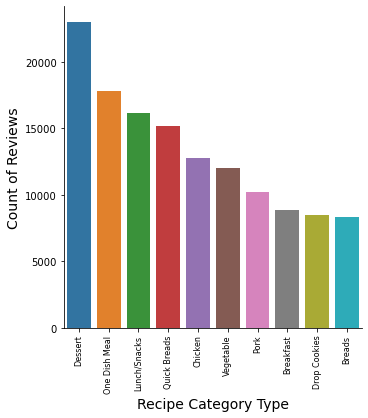

In [20]:
#Insert chart breakdown of overall recipe types
        
ax = sns.catplot(x="RecipeCategory", 
            kind="count", 
            order = df_combined["RecipeCategory"].value_counts().iloc[:10].index,
            data=df_combined,)
plt.xlabel("Recipe Category Type", size=14)
plt.ylabel("Count of Reviews", size=14)
for axes in ax.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation = 90,size = 8)
plt.show()

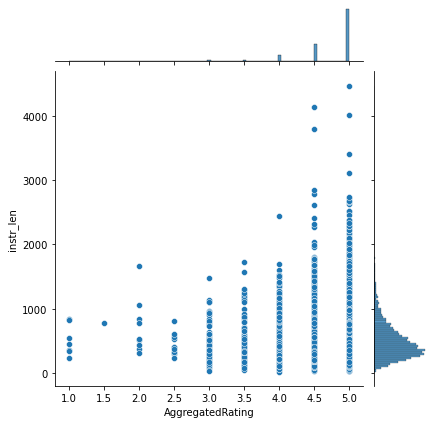

In [21]:
# Average recipe rating by instruction length. 
len_rating = df_combined.groupby('RecipeId')[['AggregatedRating','instr_len']].mean()
ax = sns.jointplot(x='AggregatedRating', y='instr_len', data=len_rating)


Text(0, 0.5, 'Average Review Score')

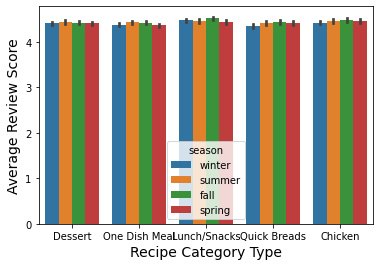

In [22]:
# Average rating by recipe type and season

ax1 = sns.barplot(x="RecipeCategory",y ='Rating', hue = 'season',
                 order = df_combined["RecipeCategory"].value_counts(normalize = True).iloc[:5].index,
                 data=df_combined,)
plt.xlabel("Recipe Category Type", size=14)
plt.ylabel("Average Review Score", size=14)


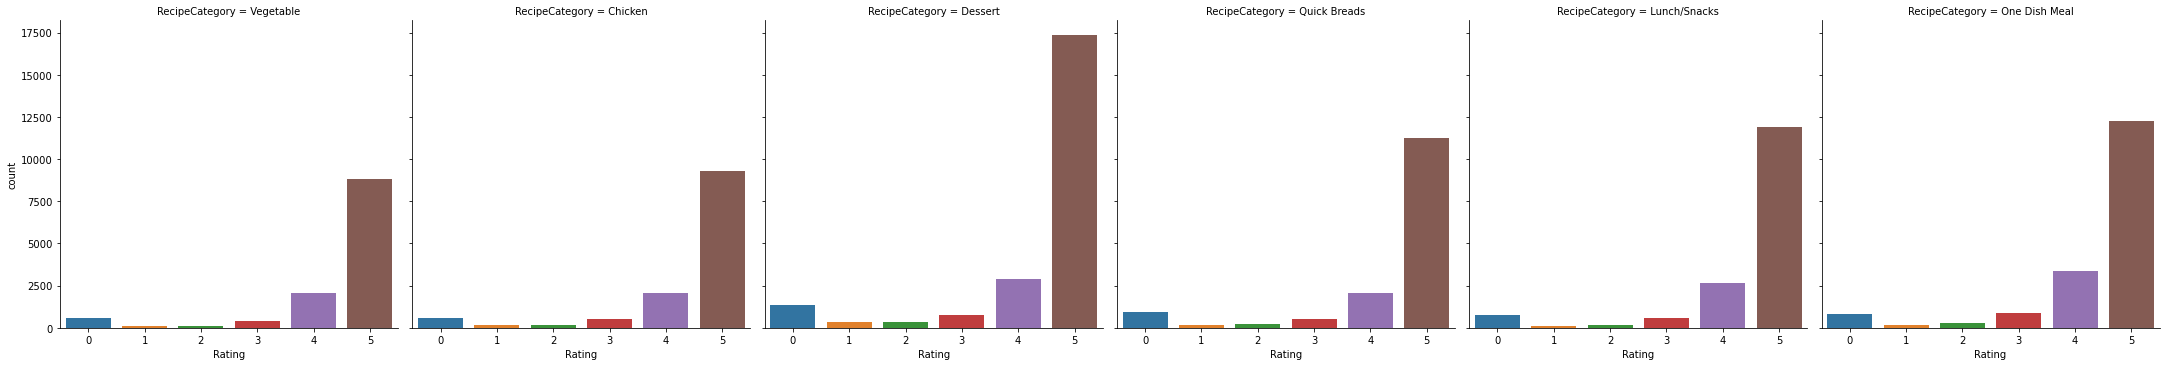

In [23]:
# distribution of ratings by recipe category

selected_cat = df_combined[df_combined.RecipeCategory.isin(['Dessert','One Dish Meal', 'Lunch/Snacks', 'Quick Breads', 'Chicken', 'Vegetable'])]
sns.catplot(x='Rating',
            col="RecipeCategory", 
            data=selected_cat,
            kind='count')

****

This is the Naive Bayes model. I used text analysis of the ingredients to predict whether or not the recipe received a high number of reviews

****

In [24]:
# slice dataframe and create field for count of reviews by recipe
nm_reviews = df_combined[['RecipeId','RecipeIngredientParts', 'RecipeCategory', 'instr_len', 'Review']]
nm_reviews = nm_reviews.groupby(['RecipeId','RecipeIngredientParts','RecipeCategory','instr_len']).count().reset_index()
nm_reviews = nm_reviews.rename(columns={"Review": "count_review"})

#create field for high count flag (will be target)
nm_reviews['High_CountFlag'] = np.where(nm_reviews['count_review'] > 10, 'High', 'Not High')
nm_reviews.head(10)

RecipeId                              RecipeIngredientParts  \
0        38  ['blueberries', 'granulated sugar', 'vanilla y...   
1        39  ['saffron', 'milk', 'hot green chili peppers',...   
2        40  ['sugar', 'lemons, rind of', 'lemon, zest of',...   
3        41  ['extra firm tofu', 'eggplant', 'zucchini', 'm...   
4        42  ['plain tomato juice', 'cabbage', 'onion', 'ca...   
5        44  ['chicken', 'butter', 'flour', 'milk', 'celery...   
6        45  ['sugar', 'margarine', 'egg', 'flour', 'salt',...   
7        47  ['butter', 'brown sugar', 'granulated sugar', ...   
8        49  ['fresh mushrooms', 'butter', 'boneless skinle...   
9        50  ['flour', 'sugar', 'baking powder', 'salt', 'e...   

    RecipeCategory  instr_len  count_review High_CountFlag  
0  Frozen Desserts        654             4       Not High  
1   Chicken Breast       1124             1       Not High  
2        Beverages        401             9       Not High  
3         Soy/Tofu       1502             2       Not High  
4        Vegetable        198             9       Not High  
5          Chicken        548            22           High  
6              Pie        605             3       Not High  
7          Dessert        487             2       Not High  
8   Chicken Breast        768            20           High  
9          Dessert        948             2       Not High

In [25]:
# set feature and outcome
x = nm_reviews[['RecipeIngredientParts']]
y = nm_reviews['High_CountFlag']

In [26]:
#lowercase keywords
x['RecipeIngredientParts'] = [i.lower() for i in nm_reviews['RecipeIngredientParts']]

<ipython-input-26-3206e45897c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['RecipeIngredientParts'] = [i.lower() for i in nm_reviews['RecipeIngredientParts']]


In [27]:
#transform the keywords into sparse matrix 
bow_transformer = CountVectorizer(ngram_range=(1, 2))
keywords = bow_transformer.fit_transform(x['RecipeIngredientParts'])

In [28]:
print('Shape of Sparse Matrix: ', keywords.shape)
print('Amount of Non-Zero occurences: ', keywords.nnz)
print ('sparsity: %.2f%%' % (100.0 * keywords.nnz / (keywords.shape[0] * keywords.shape[1])))

Shape of Sparse Matrix:  (10000, 20303)
Amount of Non-Zero occurences:  238263
sparsity: 0.12%


In [29]:
# use the tfidf transformer to weigh importance
tfidf_transformer = TfidfTransformer().fit(keywords)
x = tfidf_transformer.transform(keywords)

In [34]:
# get the ingredients with the highest weight
weights = np.asarray(x.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': bow_transformer.get_feature_names(), 'weight': weights})
weights_df_sort = weights_df.sort_values(by='weight', ascending=False).head(7)

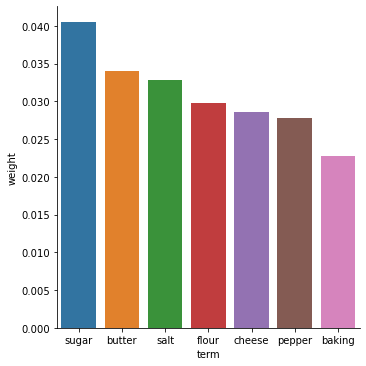

In [35]:
sns.catplot(x='term',y='weight', data=weights_df_sort, kind='bar')

In [164]:
# split the data
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3,random_state=3)

In [165]:
# create and fit the Naive Bayes model with training

review_freq_model = MultinomialNB().fit(X_train, Y_train)

In [166]:
# predict on test
y_predictions = review_freq_model.predict(X_test)

In [167]:
# evaluate
print(classification_report(Y_test, y_predictions))

acc_score = accuracy_score(Y_test, y_predictions)
conf_mat = confusion_matrix(
        Y_test, y_predictions, labels = ['High', 'Not High'])

              precision    recall  f1-score   support

        High       0.58      0.25      0.35      1267
    Not High       0.61      0.87      0.72      1733

    accuracy                           0.61      3000
   macro avg       0.60      0.56      0.54      3000
weighted avg       0.60      0.61      0.57      3000



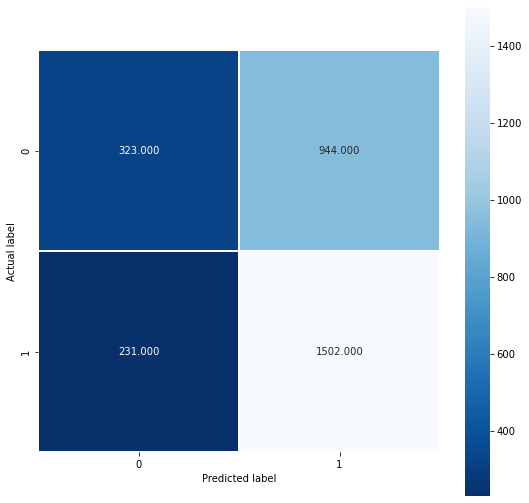

In [168]:
#confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


**** 

Next I performed a Logistic Regression. i used DataFrameMapper in order to use the fields "Recipe Category" as well as "instr_len", length of instructions. 

****

In [116]:
# create a copy of dataframe
nm_reviews_copy = nm_reviews
nm_reviews_copy

RecipeId                              RecipeIngredientParts  \
0           38  ['blueberries', 'granulated sugar', 'vanilla y...   
1           39  ['saffron', 'milk', 'hot green chili peppers',...   
2           40  ['sugar', 'lemons, rind of', 'lemon, zest of',...   
3           41  ['extra firm tofu', 'eggplant', 'zucchini', 'm...   
4           42  ['plain tomato juice', 'cabbage', 'onion', 'ca...   
...        ...                                                ...   
9995     44256  ['maraschino cherries', 'butter', 'margarine',...   
9996     44257  ['onion', 'parsley', 'celery & leaves', 'chick...   
9997     44263  ['brown sugar', 'olive oil', 'salt', 'black pe...   
9998     44266  ['eggs', 'cheddar cheese', 'salt', 'cracked bl...   
9999     44271  ['butter', 'onion', 'celery', 'garlic powder',...   

       RecipeCategory  instr_len  count_review High_CountFlag  
0     Frozen Desserts        654             4       Not High  
1      Chicken Breast       1124             1       Not High  
2           Beverages        401             9       Not High  
3            Soy/Tofu       1502             2       Not High  
4           Vegetable        198             9       Not High  
...               ...        ...           ...            ...  
9995            Candy        761             3       Not High  
9996           Lentil       1188             5       Not High  
9997        Vegetable        172            62           High  
9998        Breakfast        293             2       Not High  
9999         Chowders        357            47           High  

[10000 rows x 6 columns]

In [117]:
# recode the target into 0 and 1 for logistic regression
nm_reviews_copy['High_CountFlag']=nm_reviews_copy['High_CountFlag'].apply(lambda x: 0 if x == 'Not High' else 1)

In [118]:
# transform keywords to lowercase
nm_reviews_copy['RecipeIngredientParts'] = [i.lower() for i in nm_reviews_copy['RecipeIngredientParts']]

In [119]:
#check data
nm_reviews_copy.head()

RecipeId                              RecipeIngredientParts  \
0        38  ['blueberries', 'granulated sugar', 'vanilla y...   
1        39  ['saffron', 'milk', 'hot green chili peppers',...   
2        40  ['sugar', 'lemons, rind of', 'lemon, zest of',...   
3        41  ['extra firm tofu', 'eggplant', 'zucchini', 'm...   
4        42  ['plain tomato juice', 'cabbage', 'onion', 'ca...   

    RecipeCategory  instr_len  count_review  High_CountFlag  
0  Frozen Desserts        654             4               0  
1   Chicken Breast       1124             1               0  
2        Beverages        401             9               0  
3         Soy/Tofu       1502             2               0  
4        Vegetable        198             9               0

In [120]:
#create the data frame mapper to transform the keywords, recipe category and instruction length
mapper3 = DataFrameMapper([
    ('RecipeIngredientParts', [CountVectorizer(ngram_range=(1, 3)),
               TfidfTransformer().fit(keywords)]), ('RecipeCategory', LabelBinarizer()),('instr_len',None)
])

In [121]:
#fit mapper and set x equal to the features
x = mapper3.fit_transform(nm_reviews_copy)

In [122]:
# set target 
y = nm_reviews_copy['High_CountFlag']

In [123]:
# split the data
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3,random_state=3)

In [124]:
# Create a Logistic Regression Class object
logreg = LogisticRegression()

In [125]:
# Train the model with the training set
logreg.fit(X_train, Y_train)

/Users/kristinwendell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [126]:
# predict using test
y_pred = logreg.predict(X_test)

In [132]:
# evaluate
#print(metrics.accuracy_score(Y_test,Y_pred))
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68      1733
           1       0.53      0.37      0.44      1267

    accuracy                           0.59      3000
   macro avg       0.57      0.56      0.56      3000
weighted avg       0.58      0.59      0.58      3000



****


Next, I performed a sentiment analysis to detect the polarity of the reviews


****

In [169]:
df_combined["Review"] = df_combined["Review"].astype(str)

In [170]:
#https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity
df_combined['polarity'] = df_combined.Review.apply(detect_polarity)

In [171]:
df_combined.head()

index  RecipeId                               Name  \
0      0        38  Low-Fat Berry Blue Frozen Dessert   
1      0        38  Low-Fat Berry Blue Frozen Dessert   
2      0        38  Low-Fat Berry Blue Frozen Dessert   
3      0        38  Low-Fat Berry Blue Frozen Dessert   
4      4        39                            Biryani   

                                         Description   RecipeCategory  \
0  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
1  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
2  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
3  Make and share this Low-Fat Berry Blue Frozen ...  Frozen Desserts   
4  Make and share this Biryani recipe from Food.com.   Chicken Breast   

                               RecipeIngredientParts  \
0  ['blueberries', 'granulated sugar', 'vanilla y...   
1  ['blueberries', 'granulated sugar', 'vanilla y...   
2  ['blueberries', 'granulated sugar', 'vanilla y...   
3  ['blueberries', 'granulated sugar', 'vanilla y...   
4  ['saffron', 'milk', 'hot green chili peppers',...   

                                  RecipeInstructions  \
0  ['Toss 2 cups berries with sugar.', 'Let stand...   
1  ['Toss 2 cups berries with sugar.', 'Let stand...   
2  ['Toss 2 cups berries with sugar.', 'Let stand...   
3  ['Toss 2 cups berries with sugar.', 'Let stand...   
4  ['Soak saffron in warm milk for 5 minutes and ...   

                                            Keywords  AggregatedRating  \
0  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
1  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
2  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
3  ['Dessert', 'Low Protein', 'Low Cholesterol', ...               4.5   
4  ['Chicken Thigh & Leg', 'Chicken', 'Poultry', ...               3.0   

   instr_len  ReviewId    AuthorId          AuthorName  Rating  \
0        654    579149      596506       allisonsmommy       5   
1        654    789264     1060485           allyop135       4   
2        654   1448544  1802956262              ionnym       4   
3        654   1450744     2123645  DeliciousAsItLooks       4   
4       1124    361851      393254        cassiopeia94       3   

                                              Review DateSubmitted  \
0  Yummy, yummy, yummy! I am a big fan of fruit a...    2008-02-13   
1  very good!! the directions were alittle weird ...    2009-01-15   
2  This does taste great! I think the recipe need...    2014-07-22   
3  Tasty and refreshing! I love the creamy flavor...    2014-08-14   
4  I have an Indian friend who made this dish for...    2007-01-20   

  DateModified  season  polarity  
0   2008-02-13  winter  0.500000  
1   2009-01-15  winter  0.250000  
2   2014-07-22  summer  0.279167  
3   2014-08-14  summer  0.562500  
4   2007-01-20  winter  0.050000

array([<AxesSubplot:title={'center':'polarity'}>], dtype=object)

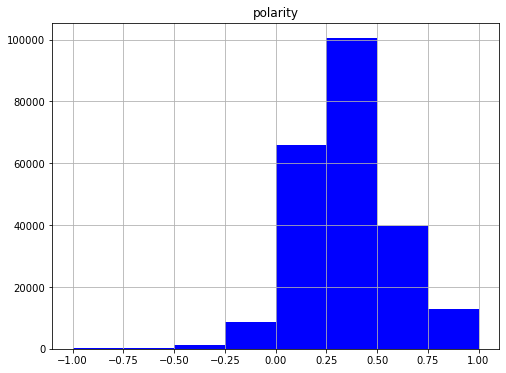

In [172]:
sentiment_df = df_combined[['RecipeCategory','season', 'polarity']]

sentiment_df = sentiment_df[sentiment_df != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="blue")

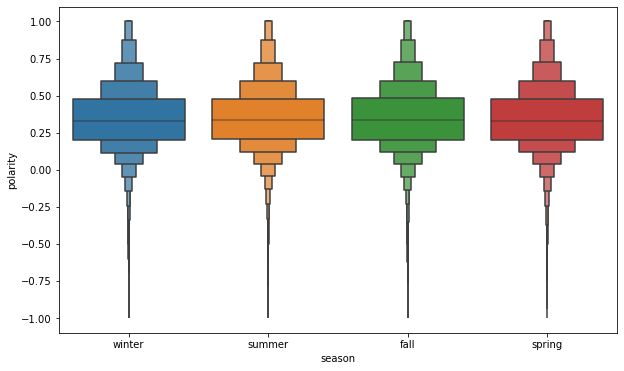

In [173]:
#sentiment by season
plt.figure(figsize=(10,6))
sns.boxenplot(x='season', y='polarity', data=sentiment_df)
plt.show();

In [185]:
#sentiment by season

sentiment_df1 = sentiment_df.loc[sentiment_df['RecipeCategory'].isin(['Dessert','One Dish Meal', 'Lunch/Snacks', 'Quick Breas', 'Chicken', 'Vegetable', 'Pork', 'Breakfast', 'Drop Cookies', 'Breads']), ['RecipeCategory','season','polarity']]

sentiment_df1



RecipeCategory  season  polarity
16          Vegetable  spring  0.427500
17          Vegetable  summer  0.428571
18          Vegetable  spring  0.120000
19          Vegetable  spring -0.166667
20          Vegetable  summer       NaN
...               ...     ...       ...
234063      Vegetable    fall  0.368750
234064      Vegetable  summer  0.600000
234065      Vegetable    fall  0.425000
234066      Breakfast  summer  0.724444
234067      Breakfast  winter  0.240000

[117541 rows x 3 columns]

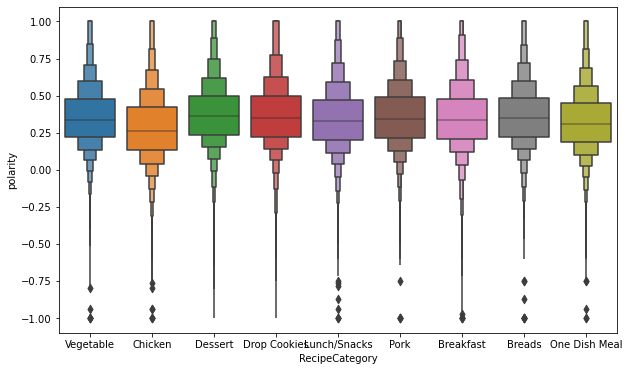

In [186]:
# sentiment by recipe category
plt.figure(figsize=(10,6))
sns.boxenplot(x='RecipeCategory', y='polarity', data=sentiment_df1)
plt.show();

**** 

Use the Guardian's API to pull recipe headlines throughout the 2020 year. Create a word cloud by season.


****

In [3]:
# Using the guardian API to get headlines
from __future__ import print_function

import requests 
import json


In [4]:
# Use Guardian API to pull based on season within the 2020 year. Pull by season to get past 200 limit
url_winter = 'https://content.guardianapis.com/search?from-date=2019-12-01&to-date=2020-02-28&q=recipe&page-size=200&show-fields=body&section=food&api-key=6fdc41bf-ffda-4cf7-8426-67e438e58b75'
req_winter = requests.get(url_winter) 
src_winter = req_winter.text
response_winter = json.loads(src_winter)['response']['results']
print(json.dumps(response_winter, indent=2, sort_keys=True))
# convert to pandas DF
response_winter = pd.DataFrame.from_dict(response_winter)

[
  {
    "apiUrl": "https://content.guardianapis.com/food/2020/jan/27/ofm-20-best-potato-recipes-claire-thomson-llapingachos",
    "fields": {
      "body": "<p>From Ecuador, llapingachos are fried potato and cheese cakes, served with a peanut sauce, coriander and chopped salsa, with quick pickled red onions and extra chilli for those who want it. This is exciting, bright cooking \u2013 the kind that is very likely to form long-standing addictions. I\u2019ve said it before: be bold with the chilli \u2013 the potatoes can take it. The llapingachos are very soft to move from pan to plate, so use a good-size fish slice or something similar.</p> <p><em><strong>Serves 4</strong></em><br><strong>floury potatoes</strong> 1kg, peeled and cut into bite-size pieces<br><strong>vegetable oil</strong><br><strong>red onions</strong> 2 small, peeled, 1 finely chopped, 1 thinly sliced<br><strong>ground paprika</strong> 2 tsp <br><strong>cheddar</strong> 100g, grated<br><strong>plain </strong><strong>

In [5]:
# combine web titles and remove stop words and chosen stop words
text_winter = " ".join(word for word in response_winter['webTitle'])
stopwords = set(STOPWORDS)
stopwords.update(['recipes','S','Cloake', 'Sweet Spot','Sweet','Spot', 'perfect',"Miers'", "Miers '", 'modern', 'Tamal Ray', 'new vegan', 'Tamal', 'Ray','Anna', 'Jones', 'Miers', 'Meera','Sodha','Rome',"Atherton", 'kitchen', 'Waste','Roddy', 'recipe', 'thomasina','food','10', 
                  'felicity', "cloake's",'david', "atherton's", 
                  "|","–","cook", "make", "rachel", "roddy's"])

In [6]:
text_winter

"Claire Thomson’s llapingachos recipe Rachel Roddy’s recipe for cheesy crespelle | A Kitchen in Rome How to cook tartiflette – recipe | Felicity Cloake’s masterclass A recipe for coq au vin | Felicity Cloake’s masterclass David Atherton’s recipe for cyclist’s malt loaf David Atherton’s recipe for banana energy balls David Atherton’s recipe for healthier flapjacks Rachel Roddy’s recipe for fennel gratin | A kitchen in Rome Tamal Ray’s recipe for blueberry cinnamon knots | The Sweet Spot A recipe for real rice pudding | Felicity Cloake’s masterclass A recipe for party blinis | Felicity Cloake’s masterclass Meera Sodha’s recipe for vegan chocolate chip cookies | The New Vegan Anna Jones’ squash and crispy kale pizza recipe | The Modern Cook David Atherton's recipe for tropical fig rolls How to cook leek and potato soup – recipe | Felicity Cloake’s masterclass Kim-Joy's recipe for sugar glass heart biscuits Liam Charles’ recipe for Valentine’s Day baked alaska  | The Sweet Spot Kim-Joy’s r

(-0.5, 1999.5, 1799.5, -0.5)

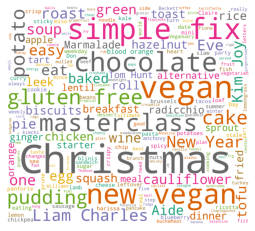

In [124]:
# create word cloud
wordcloud_winter = WordCloud(stopwords=stopwords,
                      background_color='white',
                      colormap= 'Dark2',
                      width=2000,
                      height=1800
                     ).generate(text_winter)

plt.imshow(wordcloud_winter)
plt.axis('off')

In [125]:
# Same but for spring
url_spring = 'https://content.guardianapis.com/search?from-date=2020-03-01&to-date=2020-05-31&q=recipe&page-size=200&show-fields=body&section=food&api-key=6fdc41bf-ffda-4cf7-8426-67e438e58b75'
req_spring = requests.get(url_spring) 
src_spring = req_spring.text
response_spring = json.loads(src_spring)['response']['results']
print(json.dumps(response_spring, indent=2, sort_keys=True))
# convert to pandas DF
response_spring = pd.DataFrame.from_dict(response_spring)

[
  {
    "apiUrl": "https://content.guardianapis.com/food/2020/may/13/how-to-make-kimchi-recipe-felicity-cloake-masterclass",
    "fields": {
      "body": "<p>Little known outside Korea until relatively recently, this fiery fermented cabbage has taken the world by storm. Used more like a condiment than a side dish in its homeland, a little spicy cabbage peps up no end of dishes \u2013 plus it\u2019s surprisingly easy to make and keeps for months. Which might just come in useful.</p> <p>Prep <strong>25 min, plus salting time<br></strong>Cook <strong>None, but allow at least 5 days to ferment</strong><br>Makes <strong>1 x 1-litre jar</strong></p> <p><strong>180g coarse salt</strong>, plus 2 tsp extra<br><strong>1 large cabbage</strong> \u2013 preferably a Chinese one, but any will do<br><strong>300g daikon</strong> or other radish<br><strong>1 large carrot<br>3 spring onions<br>4 garlic cloves</strong><br><strong>4cm root ginger</strong>, peeled<br><strong>40g salted shrimp</strong> (<

In [126]:
# combine web titles and remove stop words and chosen stop words
text_spring = " ".join(word for word in response_spring['webTitle'])


(-0.5, 1999.5, 1799.5, -0.5)

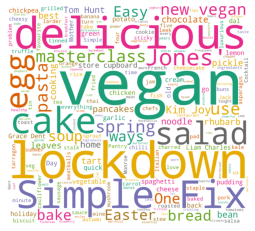

In [127]:
# create word cloud for spring
wordcloud_spring = WordCloud(stopwords=stopwords,
                      background_color='white',
                      colormap= 'Dark2',
                      width=2000,
                      height=1800
                     ).generate(text_spring)

plt.imshow(wordcloud_spring)
plt.axis('off')

In [128]:
# Same but for summer
url_summer = 'https://content.guardianapis.com/search?from-date=2020-06-01&to-date=2020-08-31&q=recipe&page-size=200&show-fields=body&section=food&api-key=6fdc41bf-ffda-4cf7-8426-67e438e58b75'
req_summer = requests.get(url_summer) 
src_summer = req_summer.text
response_summer = json.loads(src_summer)['response']['results']
print(json.dumps(response_summer, indent=2, sort_keys=True))
# convert to pandas DF
response_summer = pd.DataFrame.from_dict(response_summer)
response_summer

[
  {
    "apiUrl": "https://content.guardianapis.com/food/2020/aug/26/how-to-make-spanakopita-recipe-felicity-cloake-masterclass-filo-spinach-feta",
    "fields": {
      "body": "<p>A pie for midsummer, when greens and cheese in crackly filo have the edge on steak and kidney wrapped in suet. Spanakopita is a Greek classic: equally good warm from the oven or cold the next day, vegetarian-friendly (so long as you use a feta made without animal rennet) and utterly delicious, it\u2019s perfect picnic fare, even if you\u2019re not going any farther than your own garden.</p> <p>Prep <strong>20 min</strong><br>Cook <strong>30 min</strong><br>Makes <strong>6-8 pieces</strong></p> <p><strong>1kg adult spinach</strong>, or frozen whole-leaf spinach, defrosted (see step 1)<br><strong>Salt</strong><br><strong>1 red onion or leek</strong><br><strong>4 spring onions</strong><br><strong>2 tbsp olive oil</strong>, plus extra for brushing<br><strong>300g vegetarian feta</strong>, crumbled<br><strong>

id     type sectionId  \
0    food/2020/aug/26/how-to-make-spanakopita-recip...  article      food   
1    food/2020/jul/29/how-to-make-hummus-recipe-fel...  article      food   
2    food/2020/aug/31/rachel-roddy-favourite-recipe...  article      food   
3    food/2020/aug/22/tamal-rays-recipe-for-apricot...  article      food   
4    food/2020/aug/20/david-atherton-recipe-for-tom...  article      food   
..                                                 ...      ...       ...   
145  food/2020/jul/29/michelin-quality-food-aldi-pr...  article      food   
146  food/2020/jun/21/ofms-classic-cookbook-the-gre...  article      food   
147  food/2020/jul/13/queens-of-the-summer-puddings...  article      food   
148  food/2020/jun/23/tom-kerridge-pub-gym-restaura...  article      food   
149  food/2020/jun/05/how-to-eat-leftovers-soup-rib...  article      food   

    sectionName    webPublicationDate  \
0          Food  2020-08-26T11:00:21Z   
1          Food  2020-07-29T11:00:47Z   
2          Food  2020-08-31T10:00:05Z   
3          Food  2020-08-22T10:30:24Z   
4          Food  2020-08-20T10:30:18Z   
..          ...                   ...   
145        Food  2020-07-29T09:00:27Z   
146        Food  2020-06-21T15:00:19Z   
147        Food  2020-07-13T10:30:08Z   
148        Food  2020-06-23T09:00:42Z   
149        Food  2020-06-05T12:51:59Z   

                                              webTitle  \
0    How to make spanakopita – recipe | Felicity Cl...   
1    How to make hummus – recipe | Felicity Cloake'...   
2    Rachel Roddy's favourite recipe for arancine |...   
3    Tamal Ray's recipe for apricot croquembouche |...   
4             David Atherton's recipe for tomato salad   
..                                                 ...   
145  Michelin-quality food, Aldi prices –  how to m...   
146  OFM's classic cookbook: The Greens Cookbook by...   
147  Summer puddings: eight delicious desserts – fr...   
148  Tom Kerridge on love, weight loss and the rest...   
149                         How to eat: leftovers soup   

                                                webUrl  \
0    https://www.theguardian.com/food/2020/aug/26/h...   
1    https://www.theguardian.com/food/2020/jul/29/h...   
2    https://www.theguardian.com/food/2020/aug/31/r...   
3    https://www.theguardian.com/food/2020/aug/22/t...   
4    https://www.theguardian.com/food/2020/aug/20/d...   
..                                                 ...   
145  https://www.theguardian.com/food/2020/jul/29/m...   
146  https://www.theguardian.com/food/2020/jun/21/o...   
147  https://www.theguardian.com/food/2020/jul/13/q...   
148  https://www.theguardian.com/food/2020/jun/23/t...   
149  https://www.theguardian.com/food/2020/jun/05/h...   

                                                apiUrl  \
0    https://content.guardianapis.com/food/2020/aug...   
1    https://content.guardianapis.com/food/2020/jul...   
2    https://content.guardianapis.com/food/2020/aug...   
3    https://content.guardianapis.com/food/2020/aug...   
4    https://content.guardianapis.com/food/2020/aug...   
..                                                 ...   
145  https://content.guardianapis.com/food/2020/jul...   
146  https://content.guardianapis.com/food/2020/jun...   
147  https://content.guardianapis.com/food/2020/jul...   
148  https://content.guardianapis.com/food/2020/jun...   
149  https://content.guardianapis.com/food/2020/jun...   

                                                fields  isHosted  \
0    {'body': '<p>A pie for midsummer, when greens ...     False   
1    {'body': '<p>Remember the great hummus crisis ...     False   
2    {'body': '<p>As a food and recipe writer, I sp...     False   
3    {'body': '<p>In the patisserie world, there ar...     False   
4    {'body': '<p>Summer means it’s tomato time. If...     False   
..                                                 ...       ...   
145  {'body': '<p>Coronavirus was an earthquake for...     False   

In [129]:
# combine web titles and remove stop words and chosen stop words
text_summer = " ".join(word for word in response_summer['webTitle'])

(-0.5, 1999.5, 1799.5, -0.5)

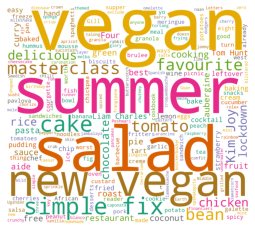

In [130]:
# create word cloud for summer
wordcloud_summer = WordCloud(stopwords=stopwords,
                      background_color='white',
                      colormap= 'Dark2',
                      width=2000,
                      height=1800
                     ).generate(text_summer)

plt.imshow(wordcloud_summer)
plt.axis('off')

In [131]:
# Same but for fall
url_fall = 'https://content.guardianapis.com/search?from-date=2020-09-01&to-date=2020-11-30&q=recipe&page-size=200&show-fields=body&section=food&api-key=6fdc41bf-ffda-4cf7-8426-67e438e58b75'
req_fall = requests.get(url_fall) 
src_fall = req_fall.text
response_fall = json.loads(src_fall)['response']['results']
print(json.dumps(response_fall, indent=2, sort_keys=True))
# convert to pandas DF
response_fall = pd.DataFrame.from_dict(response_fall)
response_fall

[
  {
    "apiUrl": "https://content.guardianapis.com/food/2020/nov/25/how-to-make-stollen-recipe-felicity-cloake",
    "fields": {
      "body": "<p>Laden with butter, dried fruit and marzipan, this festive German favourite isn\u2019t the quickest thing you\u2019ll bake this Christmas, but it may well be the most satisfying. Well wrapped, loaves will last for at least a week, making them a lovely gift, though it would be a shame not to keep one for yourself, too.</p> <p>Prep <strong>40 min, plus proofing time</strong><br>Cook <strong>45 min</strong><br>Makes <strong>1</strong></p> <p><strong>160ml whole milk<br>3 tsp dried active yeast<br>425g strong white flour</strong>, plus 1 tbsp extra for dusting<br><strong>50g caster sugar<br>1 level tsp fine salt<br>\u00bd tsp ground nutmeg or mixed spice</strong><br><strong>2 egg yolks<br>150g soft butter</strong>, plus 3 tbsp extra, to glaze<br><strong>100g dried fruit of your choice</strong><br><strong>25g mixed peel<br>2 tbsp dark rum</stro

id     type sectionId  \
0    food/2020/nov/25/how-to-make-stollen-recipe-fe...  article      food   
1    food/2020/nov/11/david-athertons-breakfast-smo...  article      food   
2    food/2020/oct/31/how-to-make-toffee-apples-rec...  article      food   
3    food/2020/oct/28/how-to-make-soda-bread-recipe...  article      food   
4    food/2020/nov/25/david-athertons-recipe-for-sw...  article      food   
..                                                 ...      ...       ...   
150  food/2020/oct/04/jay-rayner-restaurant-review-...  article      food   
151  food/2020/oct/18/crumbs-a-history-of-biscuits-...  article      food   
152  food/2020/oct/17/james-rebanks-herdwick-shephe...  article      food   
153  food/2020/sep/03/colin-the-caterpillar-at-30-h...  article      food   
154  food/2020/nov/02/taste-think-tweak-chefs-20-to...  article      food   

    sectionName    webPublicationDate  \
0          Food  2020-11-25T12:00:27Z   
1          Food  2020-11-11T13:00:38Z   
2          Food  2020-10-31T11:00:49Z   
3          Food  2020-10-28T12:00:44Z   
4          Food  2020-11-25T13:00:28Z   
..          ...                   ...   
150        Food  2020-10-04T05:00:43Z   
151        Food  2020-10-18T13:00:50Z   
152        Food  2020-10-17T15:00:24Z   
153        Food  2020-09-03T11:00:09Z   
154        Food  2020-11-02T11:31:18Z   

                                              webTitle  \
0    How to make stollen – recipe | Felicity Cloake...   
1           David Atherton's breakfast smoothie recipe   
2    How to make toffee apples – recipe | Felicity ...   
3    How to make soda bread – recipe | Felicity Clo...   
4     David Atherton's recipe for sweet potato sirenki   
..                                                 ...   
150  Daffodil Mulligan, London: ‘A certain optimism...   
151  Crumbs! A history of biscuits in 15 fantastic ...   
152  James Rebanks: ‘I don't want to be soppy, but ...   
153  Colin the Caterpillar at 30: how a supermarket...   
154  'Taste. Think. Tweak' – chefs' 20 top kitchen ...   

                                                webUrl  \
0    https://www.theguardian.com/food/2020/nov/25/h...   
1    https://www.theguardian.com/food/2020/nov/11/d...   
2    https://www.theguardian.com/food/2020/oct/31/h...   
3    https://www.theguardian.com/food/2020/oct/28/h...   
4    https://www.theguardian.com/food/2020/nov/25/d...   
..                                                 ...   
150  https://www.theguardian.com/food/2020/oct/04/j...   
151  https://www.theguardian.com/food/2020/oct/18/c...   
152  https://www.theguardian.com/food/2020/oct/17/j...   
153  https://www.theguardian.com/food/2020/sep/03/c...   
154  https://www.theguardian.com/food/2020/nov/02/t...   

                                                apiUrl  \
0    https://content.guardianapis.com/food/2020/nov...   
1    https://content.guardianapis.com/food/2020/nov...   
2    https://content.guardianapis.com/food/2020/oct...   
3    https://content.guardianapis.com/food/2020/oct...   
4    https://content.guardianapis.com/food/2020/nov...   
..                                                 ...   
150  https://content.guardianapis.com/food/2020/oct...   
151  https://content.guardianapis.com/food/2020/oct...   
152  https://content.guardianapis.com/food/2020/oct...   
153  https://content.guardianapis.com/food/2020/sep...   
154  https://content.guardianapis.com/food/2020/nov...   

                                                fields  isHosted  \
0    {'body': '<p>Laden with butter, dried fruit an...     False   
1    {'body': '<p>I love a good smoothie, and I’m a...     False   
2    {'body': '<p>My favourite kind of apple – gree...     False   
3    {'body': '<p>If you’re thinking that now is th...     False   
4    {'body': '<p>Soups can be slurped simply on th...     False   
..                                                 ...       ...   
150  {'body': '<p>Editor’s note: we have decided th...     False   

In [132]:
# combine web titles and remove stop words and chosen stop words
text_fall = " ".join(word for word in response_fall['webTitle'])

(-0.5, 1999.5, 1799.5, -0.5)

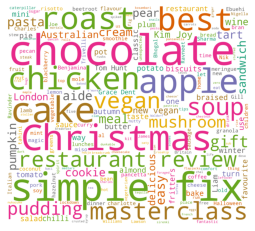

In [133]:
# create word cloud for fall
wordcloud_fall = WordCloud(stopwords=stopwords,
                      background_color='white',
                      colormap= 'Dark2',
                      width=2000,
                      height=1800
                     ).generate(text_fall)

plt.imshow(wordcloud_fall)
plt.axis('off')

****

This is the network analysis. I took the recipe and review data from 2020 and looked at the most active reviewers to see if there was overlap in terms of which recipes were being reviewed

****

In [166]:
# slice and segment the data
df_network = pd.merge(df_combined, nm_reviews, how="left", on="RecipeId")
#df_network = df_network.loc[(df_network['DateSubmitted'].dt.year == 2020) & (df_network['count_review'] > 150),['RecipeId','DateSubmitted','count_review','RecipeCategory','AuthorName']]
df_network = df_network.loc[(df_network['DateSubmitted'].dt.year == 2020) 
                            ,['RecipeId', 'Name','ReviewId','DateSubmitted','count_review','RecipeCategory', 'AuthorId','AuthorName']]
df_network['review_count'] = df_network.groupby('AuthorName')[['AuthorName']].transform('count')
df_network = df_network[df_network['review_count'] > 5]

In [167]:
df_network['AuthorName'].nunique()

13

In [168]:
# network analysis
g = nx.from_pandas_edgelist(df_network,'RecipeId', 'AuthorName',create_using=nx.DiGraph)

In [169]:
#https://stackoverflow.com/questions/55342586/assign-color-to-networkx-node-based-on-column-name
colors = []
for node in g:
    if node in df_network["RecipeId"].values:
        colors.append("lightblue")
    else: colors.append("lightgreen")

<ipython-input-169-1a1003900459>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node in df_network["RecipeId"].values:


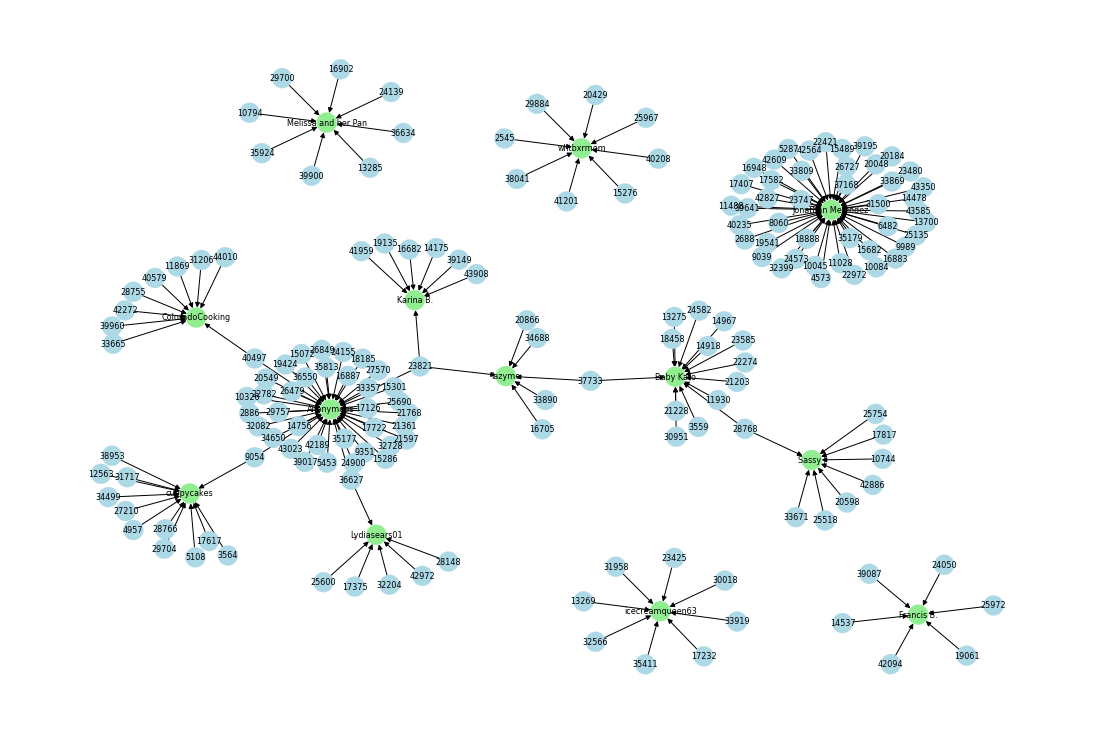

In [170]:
plt.figure(figsize=(15,10))
# <Figure size 1500x1000 with 0 Axes>

nx.draw(g, pos = nx.nx_pydot.graphviz_layout(g), \
    node_size=400, node_color=colors, linewidths=0.25, \
    font_size=8, with_labels=True)
plt.show()

In [172]:
df_combined.loc[df_combined.RecipeId == 37733, 'Name']

201850    Oven Fried Garlic Rosemary Chicken
201851    Oven Fried Garlic Rosemary Chicken
201852    Oven Fried Garlic Rosemary Chicken
201853    Oven Fried Garlic Rosemary Chicken
201854    Oven Fried Garlic Rosemary Chicken
201855    Oven Fried Garlic Rosemary Chicken
201856    Oven Fried Garlic Rosemary Chicken
201857    Oven Fried Garlic Rosemary Chicken
Name: Name, dtype: object

In [173]:
df_combined.loc[df_combined.RecipeId == 23821, 'Name']

115752    No-Bake Chocolate Oatmeal Cookies
115753    No-Bake Chocolate Oatmeal Cookies
115754    No-Bake Chocolate Oatmeal Cookies
115755    No-Bake Chocolate Oatmeal Cookies
115756    No-Bake Chocolate Oatmeal Cookies
                        ...                
116140    No-Bake Chocolate Oatmeal Cookies
116141    No-Bake Chocolate Oatmeal Cookies
116142    No-Bake Chocolate Oatmeal Cookies
116143    No-Bake Chocolate Oatmeal Cookies
116144    No-Bake Chocolate Oatmeal Cookies
Name: Name, Length: 393, dtype: object

In [174]:
df_combined.loc[df_combined.RecipeId == 9054, 'Name']

26793    Leftover Mashed Potato Pancakes
26794    Leftover Mashed Potato Pancakes
26795    Leftover Mashed Potato Pancakes
26796    Leftover Mashed Potato Pancakes
26797    Leftover Mashed Potato Pancakes
                      ...               
26919    Leftover Mashed Potato Pancakes
26920    Leftover Mashed Potato Pancakes
26921    Leftover Mashed Potato Pancakes
26922    Leftover Mashed Potato Pancakes
26923    Leftover Mashed Potato Pancakes
Name: Name, Length: 131, dtype: object